# **딥러닝 모델 훈련 및 추론**

## **1. 드라이브 연결**

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


## **2. 파라미터 설정, 데이터 로드, 데이터셋 분리**

- 데이터 전처리: MinMax Scaler
- 데이터 증강: Sliding Window

In [4]:
# ==========================================
# 1. 라이브러리 및 환경 설정 (필수)
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import warnings


# ==========================================
# 2. 데이터 로드
# ==========================================
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수 (핵심 수정: ID 반환 추가)
# ==========================================
"""
    Wafer_ID 별로 슬라이딩 윈도우를 적용하고,
    각 윈도우가 어떤 Wafer에 속하는지 ID 리스트를 함께 반환합니다.
"""
def create_sequences_with_ids(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 데이터 추출
    data_values = df_target[sensor_cols].values

    # 2. 스케일링 (Train 통계로만 Scale)
    if is_train:
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler from training data.")
        data_scaled = scaler.transform(data_values)

    # 스케일링된 데이터를 다시 DataFrame으로 매핑 (ID 그룹핑 용도)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []
    all_wafer_ids = [] # [NEW] 각 윈도우의 소스 Wafer ID를 저장할 리스트

    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터 길이가 윈도우보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            window = wafer_data[i : i + seq_len]

            all_sequences.append(window)
            all_wafer_ids.append(wafer) # [NEW] 현재 윈도우의 Wafer ID 저장

    if len(all_sequences) == 0:
        return np.array([]), np.array([]), scaler

    return np.array(all_sequences), np.array(all_wafer_ids), scaler

# ==========================================
# 4. 데이터셋 구성 및 저장
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}
SEQ_LEN = 32

# [변경] 학습 데이터 비율 설정 (0.8 -> 0.6으로 변경 추천)
TRAIN_RATIO = 0.6

print(f"\n--- Preprocessing Data (Train Ratio: {TRAIN_RATIO*100}%) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 실험 데이터 필터링
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
    if exp_df.empty:
        continue

    # 2. Train / Test Split (Wafer ID 기준)
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    # [수정] 비율 적용 (Normal Wafer만 분할)
    n_train = int(len(normal_wafer_ids) * TRAIN_RATIO)

    train_ids = normal_wafer_ids[:n_train]
    test_norm_ids = normal_wafer_ids[n_train:]

    # ID 기반 데이터프레임 분할
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    print(f"  - Total Normal: {len(normal_wafer_ids)}")
    print(f"  -> Train Normal : {len(train_ids)} ({TRAIN_RATIO*100:.0f}%)")
    print(f"  -> Test Normal  : {len(test_norm_ids)} ({(1-TRAIN_RATIO)*100:.0f}%)")
    print(f"  -> Test Fault   : {len(fault_wafer_ids)} (100%)")

    # 3. 시퀀스 생성 (X, Wafer_ID 반환)
    # (1) Train: Scaler 학습 (Fit)
    X_train, y_train_ids, scaler = create_sequences_with_ids(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal: Scaler 적용 (Transform)
    X_test_norm, y_test_norm_ids, _ = create_sequences_with_ids(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False
    )

    # (3) Test Fault: Scaler 적용 (Transform)
    if not test_fault_df.empty:
        X_test_fault, y_test_fault_ids, _ = create_sequences_with_ids(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False
        )
    else:
        X_test_fault, y_test_fault_ids = np.array([]), np.array([])

    # 4. Dictionary에 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_norm,
        'X_test_fault': X_test_fault,
        'ids_train': y_train_ids,
        'ids_test_norm': y_test_norm_ids,
        'ids_test_fault': y_test_fault_ids,
        'scaler': scaler
    }

print("\n✅ Data preprocessing with new ratio completed.")

Loading data from: /content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx

--- Preprocessing Data (Train Ratio: 60.0%) ---

Processing Experiment: l29
  - Total Normal: 34
  -> Train Normal : 20 (60%)
  -> Test Normal  : 14 (40%)
  -> Test Fault   : 9 (100%)

Processing Experiment: l31
  - Total Normal: 37
  -> Train Normal : 22 (60%)
  -> Test Normal  : 15 (40%)
  -> Test Fault   : 6 (100%)

Processing Experiment: l33
  - Total Normal: 37
  -> Train Normal : 22 (60%)
  -> Test Normal  : 15 (40%)
  -> Test Fault   : 6 (100%)

✅ Data preprocessing with new ratio completed.


## **3. 함수 설정**

In [5]:
# ==========================================
# 3. 유틸리티 함수 (데이터 로드, 집계, 시각화)
# ==========================================
def get_data_loaders(exp_id, datasets_dict, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")
    data = datasets_dict[exp_id]

    # 데이터 추출
    X_train = data['X_train']
    X_test_norm = data['X_test_norm'] # 수정된 키 이름 사용
    ids_test_norm = data['ids_test_norm']
    X_test_fault = data['X_test_fault']
    ids_test_fault = data['ids_test_fault']

    # Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # DataLoader (Train only)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, (test_norm_tensor, ids_test_norm), (test_fault_tensor, ids_test_fault)

def aggregate_wafer_scores(window_scores, wafer_ids, method='max'):
    # DataFrame핑하여 GroupBy 연산
    df_temp = pd.DataFrame({'Wafer_ID': wafer_ids, 'Score': window_scores})

    if method == 'max':
        grouped = df_temp.groupby('Wafer_ID')['Score'].max()
    else:
        grouped = df_temp.groupby('Wafer_ID')['Score'].mean()

    return grouped.index.values, grouped.values

def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance (Wafer-Level)", fontsize=16, fontweight='bold')

    # Confusion Matrix
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    axes[0].set_title("Confusion Matrix")

    # Scatter Plot (Wafer Scores)
    normal_idx = np.where(labels == 0)[0]
    fault_idx = np.where(labels == 1)[0]

    axes[1].scatter(normal_idx, scores[normal_idx], color='blue', label='Normal', alpha=0.6, s=20)
    axes[1].scatter(fault_idx, scores[fault_idx], color='red', label='Fault', alpha=0.6, s=20)
    axes[1].axhline(y=threshold, color='green', linestyle='--', label='Threshold')
    axes[1].set_title("Wafer Anomaly Scores")
    axes[1].legend()

    # ROC Curve
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[2].set_title("ROC Curve")
    axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def evaluate_performance(model_name, exp_id, scores, labels):
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores)

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Wafer-Level Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1


# **모델 구현 및 추론**

In [6]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [
                CausalConv1d(in_channels, out_channels, kernel_size, dilation=dilation_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TRACE_GPT(nn.Module):
    def __init__(self, num_sensors, seq_len, d_model=128, n_head=8, num_layers=6, resolution=100, dropout=0.1):
        super(TRACE_GPT, self).__init__()
        self.num_sensors = num_sensors
        self.seq_len = seq_len
        self.resolution = resolution
        self.d_model = d_model

        # TCN 4층 (Receptive Field 확보)
        tcn_channels = [d_model] * 4

        self.tcn = TemporalConvNet(
            num_inputs=num_sensors + 1, # +1 for Time Index
            num_channels=tcn_channels,
            kernel_size=3,
            dropout=dropout
        )

        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=d_model, nhead=n_head, batch_first=True, dropout=dropout),
            num_layers=num_layers
        )

        self.output_head = nn.Linear(d_model, num_sensors * resolution)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        batch_size, curr_seq_len, _ = x.size()

        # Absolute Positional Embedding (Robust to length change)
        steps = torch.arange(curr_seq_len, device=x.device, dtype=torch.float32)
        time_idx = (steps / self.seq_len).unsqueeze(0).unsqueeze(2)
        time_idx = time_idx.expand(batch_size, -1, -1)

        x_emb = torch.cat([x, time_idx], dim=2)

        x_tcn = x_emb.permute(0, 2, 1)
        x_tcn = self.tcn(x_tcn)
        x_tcn = x_tcn.permute(0, 2, 1)

        tgt_mask = self._generate_square_subsequent_mask(curr_seq_len).to(x.device)
        output = self.transformer_decoder(x_tcn, x_tcn, tgt_mask=tgt_mask)

        logits = self.output_head(output)
        logits = logits.view(batch_size, curr_seq_len, self.num_sensors, self.resolution)

        return logits


def quantize_data(x, resolution=100):
    x_idx = (x * (resolution - 1)).long()
    x_idx = torch.clamp(x_idx, 0, resolution - 1)
    return x_idx

def train_trace_gpt(model, train_loader, optimizer, epoch, device, resolution=100):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    for (data,) in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Input(0~T-1) -> Target(1~T)
        input_seq = data[:, :-1, :]
        target_seq = data[:, 1:, :]
        target_idx = quantize_data(target_seq, resolution)

        output_logits = model(input_seq)

        loss = criterion(
            output_logits.reshape(-1, resolution),
            target_idx.reshape(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    if (epoch + 1) % 2 == 0: # 2 epoch마다 로그 출력
        print(f"Epoch [{epoch+1}] Loss: {avg_loss:.4f}")
    return avg_loss

def calculate_window_scores(model, data_tensor, device, batch_size=32, resolution=100):
    model.eval()
    all_scores = []
    criterion = nn.CrossEntropyLoss(reduction='none')

    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (data,) in loader:
            data = data.to(device)
            input_seq = data[:, :-1, :]
            target_seq = data[:, 1:, :]
            target_idx = quantize_data(target_seq, resolution)

            output_logits = model(input_seq)

            loss_element = criterion(
                output_logits.reshape(-1, resolution),
                target_idx.reshape(-1)
            )
            loss_element = loss_element.view(input_seq.shape[0], input_seq.shape[1], input_seq.shape[2])

            # Window별 평균 Loss
            score_window = loss_element.mean(dim=[1, 2])
            all_scores.extend(score_window.cpu().numpy())

    return np.array(all_scores)

Using device: cuda

>>> Running TRACE-GPT (Fixed) on Experiment: l29

📊 [Data Setup] Experiment: l29
Training started...
Epoch [2] Loss: 2.5703
Epoch [4] Loss: 2.3892
Epoch [6] Loss: 2.2800
Epoch [8] Loss: 2.2160
Epoch [10] Loss: 2.1795
Calculating Window Scores...
Aggregating Wafer Scores...

📌 [TRACE-GPT(Fixed) - l29] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.935932


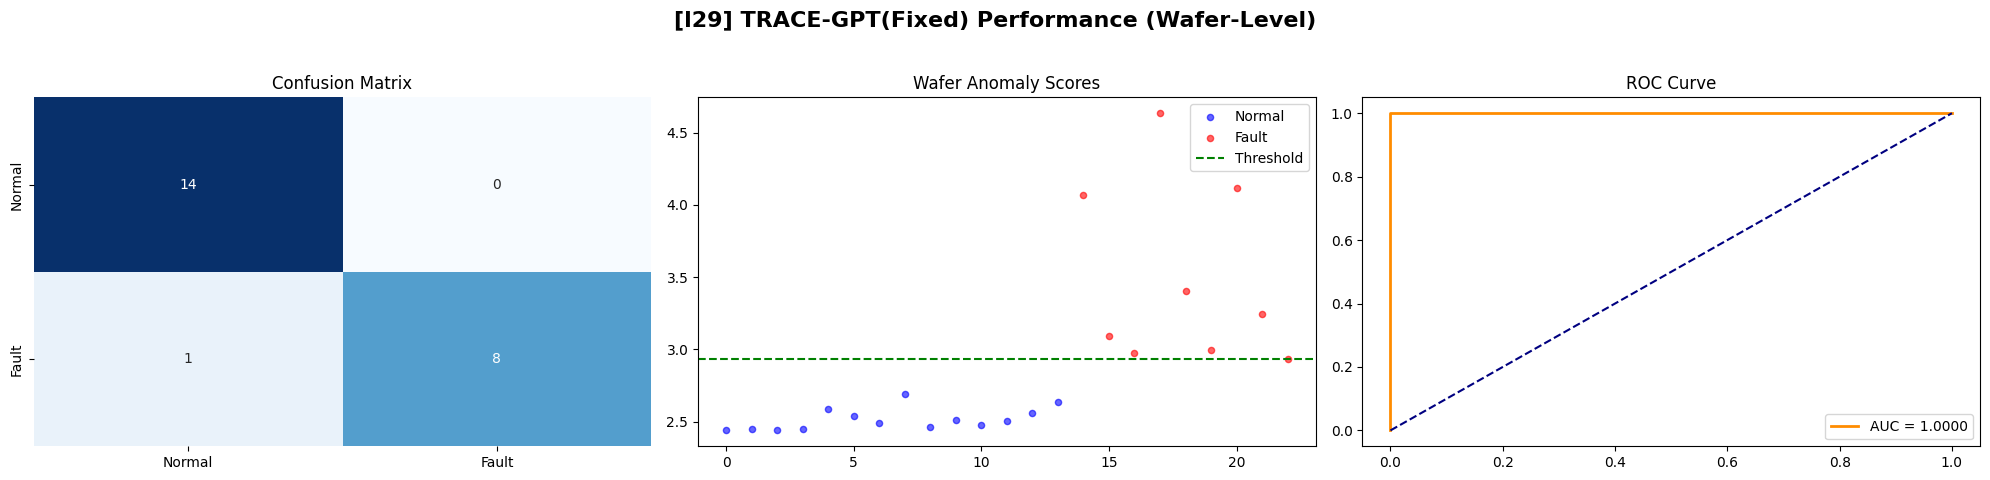


>>> Running TRACE-GPT (Fixed) on Experiment: l31

📊 [Data Setup] Experiment: l31
Training started...
Epoch [2] Loss: 2.5377
Epoch [4] Loss: 2.3641
Epoch [6] Loss: 2.2605
Epoch [8] Loss: 2.1983
Epoch [10] Loss: 2.1575
Calculating Window Scores...
Aggregating Wafer Scores...

📌 [TRACE-GPT(Fixed) - l31] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.934892


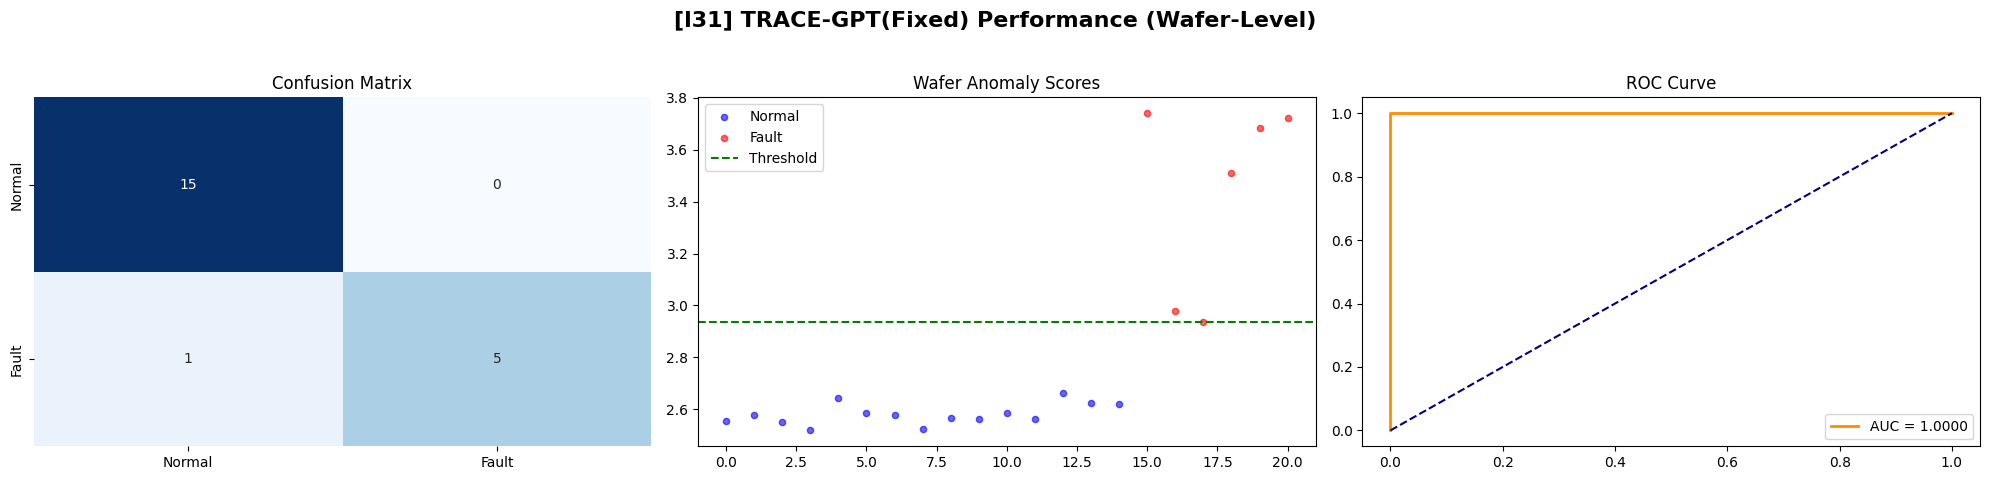


>>> Running TRACE-GPT (Fixed) on Experiment: l33

📊 [Data Setup] Experiment: l33
Training started...
Epoch [2] Loss: 2.5622
Epoch [4] Loss: 2.3834
Epoch [6] Loss: 2.2685
Epoch [8] Loss: 2.1913
Epoch [10] Loss: 2.1480
Calculating Window Scores...
Aggregating Wafer Scores...

📌 [TRACE-GPT(Fixed) - l33] Wafer-Level Summary
   - AUROC         : 1.0000
   - Best F1-Score : 1.0000
   - Best Threshold: 2.761596


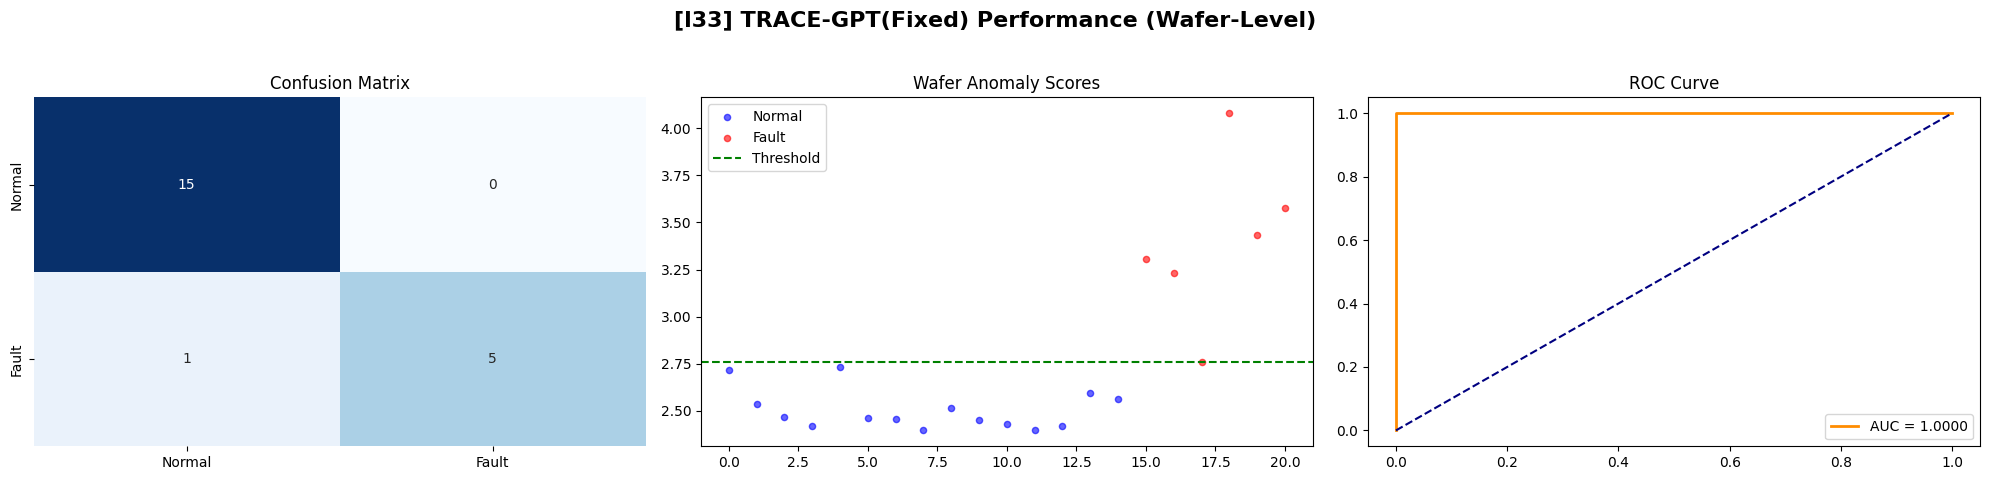


✅ All experiments finished.
{'l29': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}, 'l31': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}, 'l33': {'AUC': np.float64(1.0), 'F1': np.float64(1.0)}}


In [7]:
# ==========================================
# 5. 메인 실행 루프
# ==========================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 하이퍼파라미터
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
D_MODEL = 64
RESOLUTION = 100

results = {}
# datasets 변수는 이전 셀(전처리 코드)에서 생성된 것을 그대로 사용합니다.
target_experiments = ['l29', 'l31', 'l33']

for exp_id in target_experiments:
    # 데이터셋 존재 여부 확인
    if exp_id not in datasets:
        print(f"Skipping {exp_id}: Dataset not found.")
        continue

    print(f"\n>>> Running TRACE-GPT (Fixed) on Experiment: {exp_id}")

    # 1. 데이터 로드
    train_loader, (test_norm, ids_norm), (test_fault, ids_fault) = get_data_loaders(exp_id, datasets, BATCH_SIZE)

    # 2. 모델 초기화
    num_sensors = test_norm.shape[2]
    seq_len_input = test_norm.shape[1] # 32

    model = TRACE_GPT(
        num_sensors=num_sensors,
        seq_len=seq_len_input - 1, # Next token prediction이므로 길이는 31
        d_model=D_MODEL,
        resolution=RESOLUTION
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 3. 학습
    print("Training started...")
    for epoch in range(NUM_EPOCHS):
        train_trace_gpt(model, train_loader, optimizer, epoch, device, RESOLUTION)

    # 4. 추론 (Window Score)
    print("Calculating Window Scores...")
    norm_window_scores = calculate_window_scores(model, test_norm, device, BATCH_SIZE, RESOLUTION)

    if len(test_fault) > 0:
        fault_window_scores = calculate_window_scores(model, test_fault, device, BATCH_SIZE, RESOLUTION)
    else:
        fault_window_scores = np.array([])

    # 5. 집계 (Wafer Aggregation - Max Strategy)
    print("Aggregating Wafer Scores...")
    # Normal
    _, norm_wafer_scores = aggregate_wafer_scores(norm_window_scores, ids_norm, method='max')
    norm_labels = np.zeros(len(norm_wafer_scores))

    # Fault
    if len(fault_window_scores) > 0:
        _, fault_wafer_scores = aggregate_wafer_scores(fault_window_scores, ids_fault, method='max')
        fault_labels = np.ones(len(fault_wafer_scores))
    else:
        fault_wafer_scores = np.array([])
        fault_labels = np.array([])

    # 병합
    final_scores = np.concatenate([norm_wafer_scores, fault_wafer_scores])
    final_labels = np.concatenate([norm_labels, fault_labels])

    # 6. 평가
    auc_score, f1 = evaluate_performance("TRACE-GPT(Fixed)", exp_id, final_scores, final_labels)
    results[exp_id] = {'AUC': auc_score, 'F1': f1}

print("\n✅ All experiments finished.")
print(results)